In [2]:
import lsdb

In [3]:
ztf = lsdb.read_hipscat("https://data.lsdb.io/unstable/ztf/ztf_dr14/", columns=["ra", "dec", "ps1_objid", "mean_mag_r"])
ztf

,ra,dec,ps1_objid,mean_mag_r
npartitions=2352,,,,
0,double[pyarrow],double[pyarrow],int64[pyarrow],double[pyarrow]
18014398509481984,...,...,...,...
...,...,...,...,...
13830554455654793216,...,...,...,...
18446744073709551615,...,...,...,...


(<module 'matplotlib.pyplot' from '/astro/users/seanmcgu/anaconda3/envs/lsdb/lib/python3.10/site-packages/matplotlib/pyplot.py'>,
 <WCSAxes: title={'center': 'HATS HEALPix structure of ztf_dr14'}>)

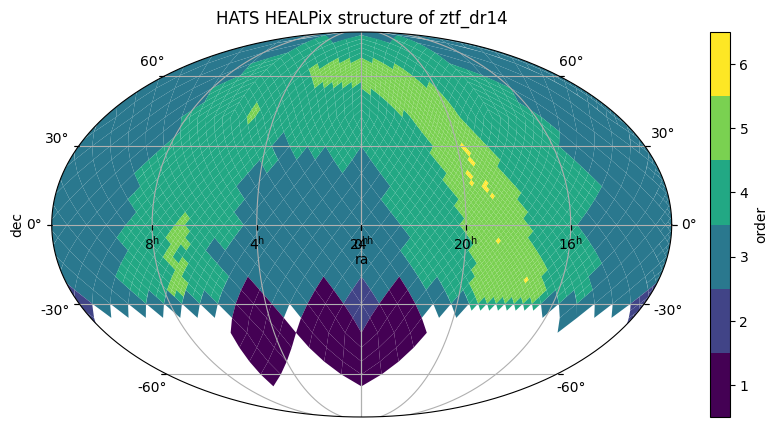

In [4]:
ztf.plot_pixels()

(<module 'matplotlib.pyplot' from '/astro/users/seanmcgu/anaconda3/envs/lsdb/lib/python3.10/site-packages/matplotlib/pyplot.py'>,
 <WCSAxes: title={'center': 'HATS HEALPix structure of ztf_dr14'}>)

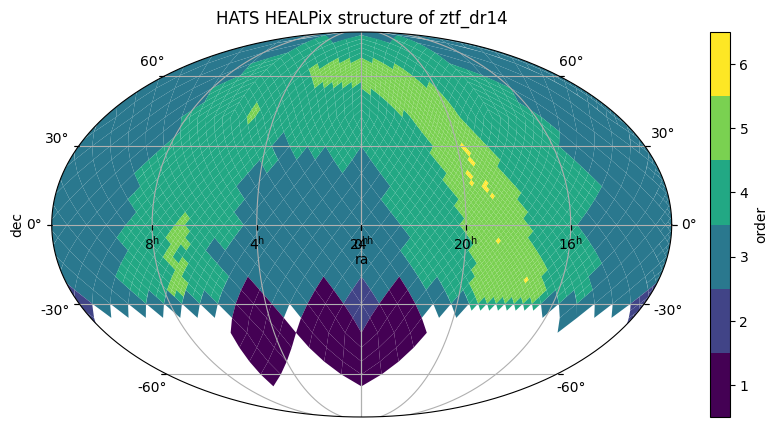

In [5]:
ztf.hc_structure.plot_pixels()

In [6]:
ra = 10
dec = 10
radius = 7200

In [7]:
ztf_cone = ztf.cone_search(ra, dec, radius)
ztf_cone

,ra,dec,ps1_objid,mean_mag_r
npartitions=4,,,,
5098074778183401472,double[pyarrow],double[pyarrow],int64[pyarrow],double[pyarrow]
5152117973711847424,...,...,...,...
5494391545392005120,...,...,...,...
5548434740920451072,...,...,...,...
5566449139429933056,...,...,...,...


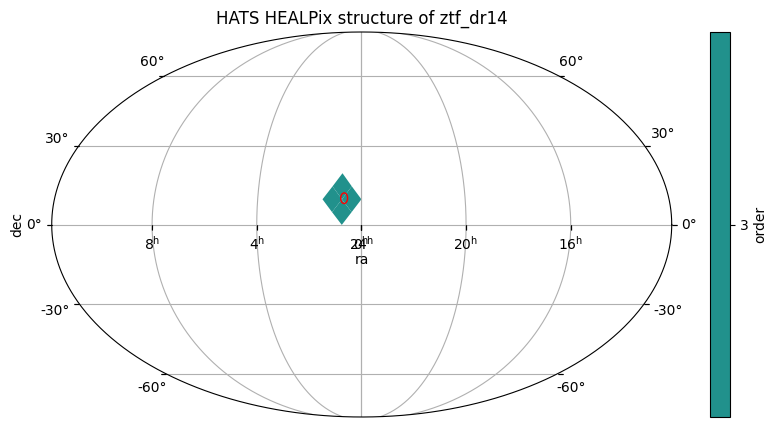

In [8]:
from matplotlib.patches import Circle, CirclePolygon

plt, ax = ztf_cone.plot_pixels()
c = Circle((ra, dec), radius/3600, edgecolor='r', facecolor='none', transform=ax.get_transform('icrs'))

ax.add_patch(c)

(<module 'matplotlib.pyplot' from '/astro/users/seanmcgu/anaconda3/envs/lsdb/lib/python3.10/site-packages/matplotlib/pyplot.py'>,
 <WCSAxes: >)

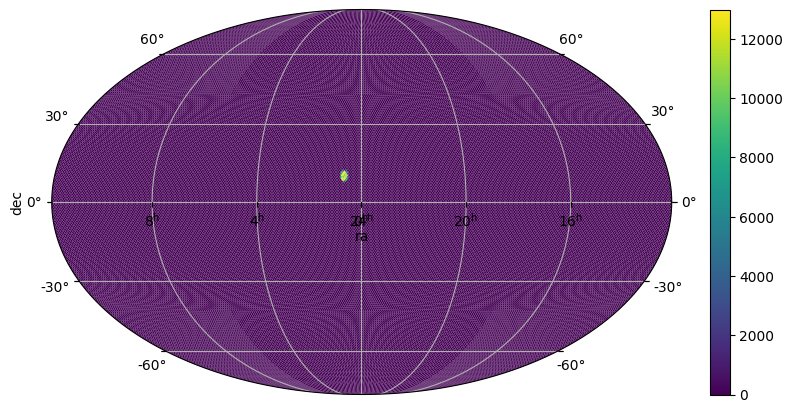

In [9]:
ztf_cone.skymap(lambda df, p: len(df), order=6, default_value=0)

(<module 'matplotlib.pyplot' from '/astro/users/seanmcgu/anaconda3/envs/lsdb/lib/python3.10/site-packages/matplotlib/pyplot.py'>,
 <WCSAxes: >)

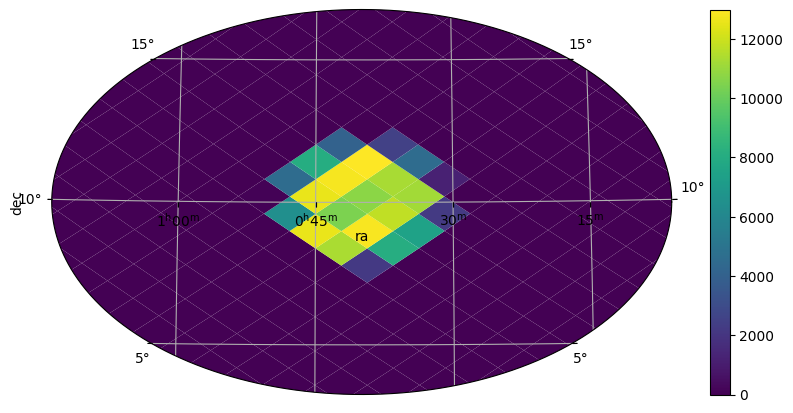

In [10]:
from astropy.coordinates import SkyCoord
import astropy.units as u
ztf_cone.skymap(lambda df, p: len(df), order=6, default_value=0, plotting_args= {"fov": (15 * u.deg, 15 * u.deg), "center": SkyCoord(ra, dec, unit="deg", frame="icrs")})

In [11]:
ztf_source = lsdb.read_hipscat('https://data.lsdb.io/unstable/ztf/ztf_zource/', columns=["ps1_objid", "band", "mag",  "mjd"])
ztf_source

,ps1_objid,band,mag,mjd
npartitions=41679,,,,
0,int64[pyarrow],string[pyarrow],float[pyarrow],double[pyarrow]
4503599627370496,...,...,...,...
...,...,...,...,...
13833932155375321088,...,...,...,...
18446744073709551615,...,...,...,...


In [12]:
ztf_with_lcs = ztf_cone.join_nested(
    ztf_source , left_on = "ps1_objid", right_on="ps1_objid",nested_column_name="ztf_lc"
)
ztf_with_lcs

/astro/users/seanmcgu/lsdb_deploy/src/lsdb/dask/join_catalog_data.py:296: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


,ra,dec,ps1_objid,mean_mag_r,ztf_lc
npartitions=9,,,,,
5113837376879198208,double[pyarrow],double[pyarrow],int64[pyarrow],double[pyarrow],"nested<band: [string], mag: [float], mjd: [dou..."
5114963276786040832,...,...,...,...,...
...,...,...,...,...,...
5550686540734136320,...,...,...,...,...
18446744073709551615,...,...,...,...,...


In [14]:
a = ztf_with_lcs.compute()

In [33]:
a["mean_mag_r"]

_hipscat_index
5114819765226962944     21.21144
5114819779516956672     18.78701
5114819790220820480    17.182995
5114820030499913728    21.335213
5114820043049271296    20.088624
                         ...    
5551342277844008960    20.572681
5551342281291726848     21.34685
5551342435830857728    20.951988
5551355068831236096    21.379094
5551355135482920960    21.122351
Name: mean_mag_r, Length: 181658, dtype: double[pyarrow]

In [63]:
filtered = ztf_with_lcs.query("ztf_lc.band == 'r'")
filtered = filtered.query("mean_mag_r < 15 and mean_mag_r > 14.8")

In [64]:
filtered = filtered.dropna()

In [65]:
len(filtered.compute())

274

In [66]:
import numpy as np


def std_mag(ra, dec, mag):
    return {"ra": ra, "dec": dec, "mag_std": np.std(mag)}

mag_stds = filtered.reduce(
    std_mag, "ra", "dec", "ztf_lc.mag", meta={"ra": float, "dec": float, "mag_std": float}
)

In [67]:
computed = mag_stds.compute()
computed

,ra,dec,mag_std
_hipscat_index,,,
5114822162082955264,10.156267,8.042934,0.034804
5114918103548952576,10.045550,8.102234,0.029527
5114921829663768576,9.913473,8.080573,0.027855
5114926816527646720,9.988748,8.179838,0.028710
5114940338871468032,9.570993,8.100530,0.049075
...,...,...,...
5551253887320588288,9.138191,11.565219,0.081592
5551269129308078080,9.372561,11.665501,0.021593
5551288828846669824,8.969877,11.692016,0.021907


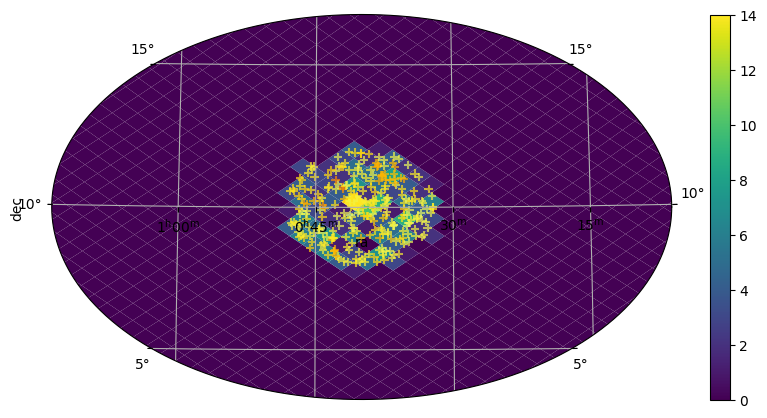

In [72]:
plt, ax = filtered.skymap(lambda df, p: len(df), order=7, default_value=0, plotting_args= {"fov": (15 * u.deg, 15 * u.deg), "center": SkyCoord(ra, dec, unit="deg", frame="icrs")})

ax.scatter(computed["ra"].to_numpy(), computed["dec"].to_numpy(), c = computed["mag_std"].to_numpy(), transform=ax.get_transform('icrs'), marker='+', alpha=0.7, cmap="Wistia")